In [1]:
# To prevent the annoying warnings

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
dataframe = pd.read_csv('Data/Train_Test_Data_Credit_Scoring.csv')

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [5]:
dataframe.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [6]:
dataframe.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

# 1. Data Preprocessing for Prediction

## 1.1 Cleaning the Columns

### 1.1.1 Month

In [7]:
encoded_months = pd.get_dummies(dataframe['Month'], prefix='Month')
dataframe = pd.concat([dataframe.drop('Month', axis=1), encoded_months], axis=1)

### 1.1.2 Age

In [8]:
def extract_number(s):
    return int(re.sub(r"[^0-9]", "", s))

dataframe['Age'] = dataframe['Age'].apply(extract_number)
dataframe.loc[dataframe['Age'] > 100, 'Age'] = np.nan
medians = dataframe.groupby('Customer_ID')['Age'].transform('median')
dataframe['Age'].fillna(medians, inplace=True)

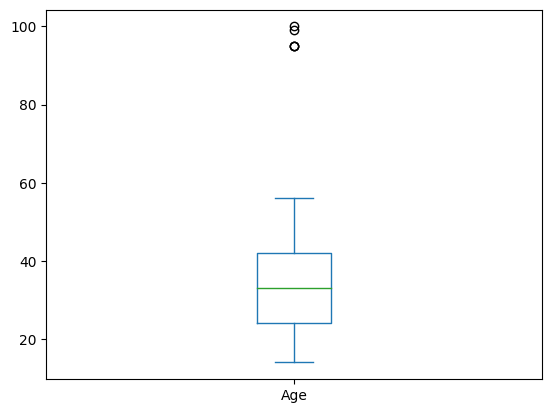

In [9]:
dataframe['Age'].plot(kind='box');

From the above boxplot, few outliers are visible, hence we will drop those age which are greater than ``60``

In [10]:
dataframe = dataframe[dataframe['Age'] <= 60]

### 1.1.3 Occupation

In [11]:
dataframe['Occupation'].replace("_______", "Not_Specified", inplace=True)
encoded_occupations = pd.get_dummies(dataframe['Occupation'], prefix='Occupation')
dataframe = pd.concat([dataframe.drop('Occupation', axis=1), encoded_occupations], axis=1)

### 1.1.4 Annual_Income

In [12]:
def extract_float(s):
    return float(re.sub(r"[^0-9.]", "", s))

dataframe['Annual_Income'] = dataframe['Annual_Income'].apply(extract_float)
dataframe['Annual_Income'] = dataframe['Annual_Income'].astype('float64')
dataframe['Annual_Income'] = dataframe['Annual_Income'].round(2)

# Dropping outliers, some of the annual salaries are around 24 million which is unusual. 
# There are approx 2000+ outliers. They may not be outliers, but they might affect the 
# model performance. Hence we decided to drop those rows.

# Calculate Q1, Q3, and IQR
Q1 = dataframe['Annual_Income'].quantile(0.25)
Q3 = dataframe['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
dataframe = dataframe[(dataframe['Annual_Income'] >= lower_bound) & (dataframe['Annual_Income'] <= upper_bound)]

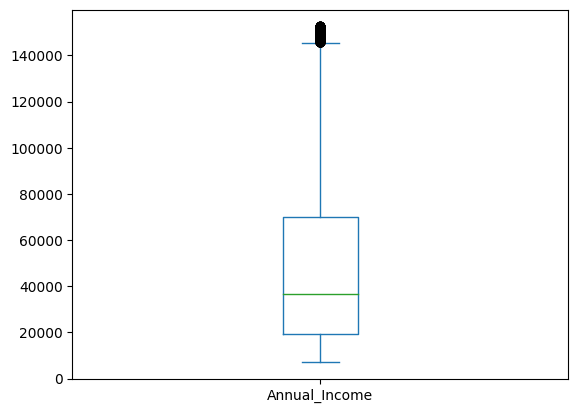

In [13]:
dataframe['Annual_Income'].plot(kind='box');

```Annual_Income``` values looks better now. According to boxplot still we see few number of outliers. This can be ignored as they are not realatively very high compared to other values.

### 1.1.5 Monthly_Inhand_Salary

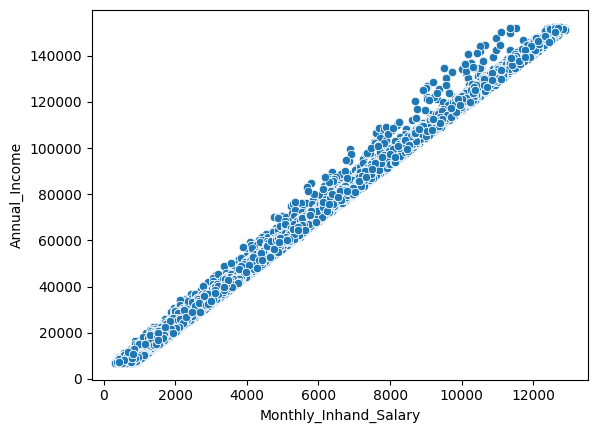

In [14]:
sns.scatterplot(x='Monthly_Inhand_Salary', y='Annual_Income', data=dataframe);

From the above plot it is evident that there is positive corelation between ``Monthly_Inhand_Salary`` and ``Annual_Income``. Hence we will apply linear regression to fill the missing nan values in the ``Monthly_Inhand_Salary`` column.

In [15]:
not_na = dataframe[dataframe['Monthly_Inhand_Salary'].notna()]
are_na = dataframe[dataframe['Monthly_Inhand_Salary'].isna()]

# Reshape data and train the model
X_train = not_na['Annual_Income'].values.reshape(-1, 1)
y_train = not_na['Monthly_Inhand_Salary']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict the missing Monthly_Inhand_Salary values
X_test = are_na['Annual_Income'].values.reshape(-1, 1)
predicted_values = lr_model.predict(X_test)

# Fill the NaN values in the original dataframe with the predicted values
dataframe.loc[dataframe['Monthly_Inhand_Salary'].isna(), 'Monthly_Inhand_Salary'] = predicted_values

### 1.1.6 Num_Bank_Accounts

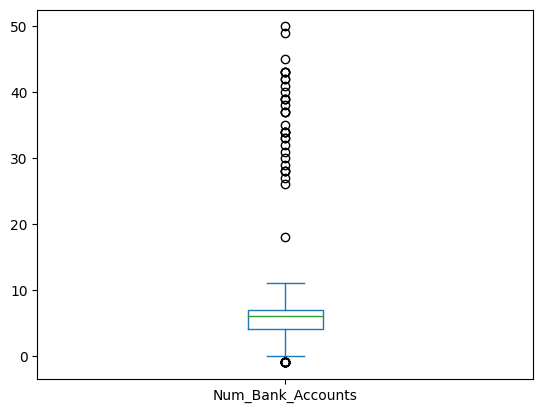

In [16]:
dataframe[dataframe['Num_Bank_Accounts'] <= 50]['Num_Bank_Accounts'].plot(kind='box');

Using the above box plot we will consider ``Num_Bank_Accounts > 15`` as an oulier and then try to fit a Median using Customer_ID.

In [17]:
dataframe.loc[dataframe['Num_Bank_Accounts'] == 0, 'Num_Bank_Accounts'] = 1
dataframe.loc[dataframe['Num_Bank_Accounts'] < 0, 'Num_Bank_Accounts'] = np.nan
dataframe.loc[dataframe['Num_Bank_Accounts'] > 15, 'Num_Bank_Accounts'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Bank_Accounts'].transform('median')
dataframe['Num_Bank_Accounts'].fillna(medians, inplace=True)

### 1.1.7 Num_Credit_Card

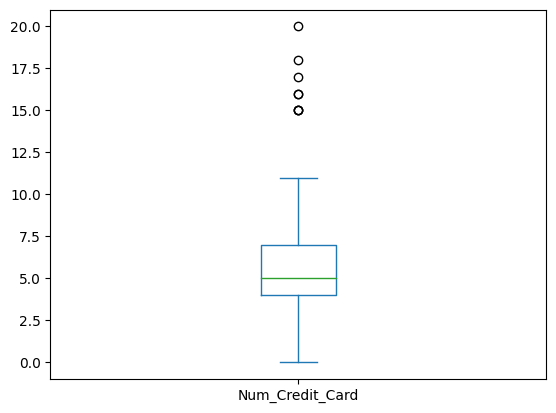

In [18]:
dataframe[dataframe['Num_Credit_Card'] <= 20]['Num_Credit_Card'].plot(kind='box');

Using the above box plot we will consider ``Num_Credit_Card > 12`` as an oulier and then try to fit a Median using Customer_ID.

In [19]:
dataframe.loc[dataframe['Num_Credit_Card'] > 12, 'Num_Credit_Card'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Credit_Card'].transform('median')
dataframe['Num_Credit_Card'].fillna(medians, inplace=True)

### 1.1.8 Interest_Rate

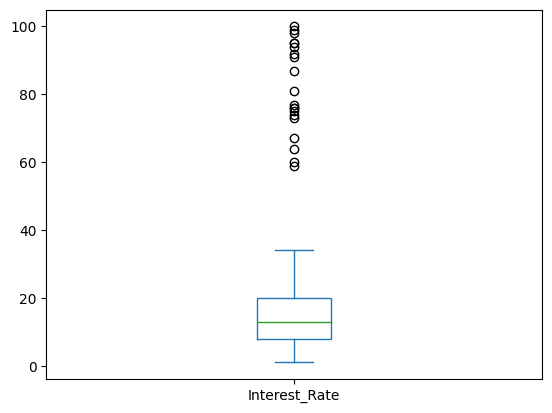

In [20]:
dataframe[dataframe['Interest_Rate'] <= 100]['Interest_Rate'].plot(kind='box');

Using the above box plot we will consider ``Interest_Rate > 35`` as an oulier and then try to fit a Median using Customer_ID.

In [21]:
dataframe.loc[dataframe['Interest_Rate'] > 35, 'Interest_Rate'] = np.nan
medians = dataframe.groupby('Customer_ID')['Interest_Rate'].transform('median')
dataframe['Interest_Rate'].fillna(medians, inplace=True)

### 1.1.9 Num_of_Loan

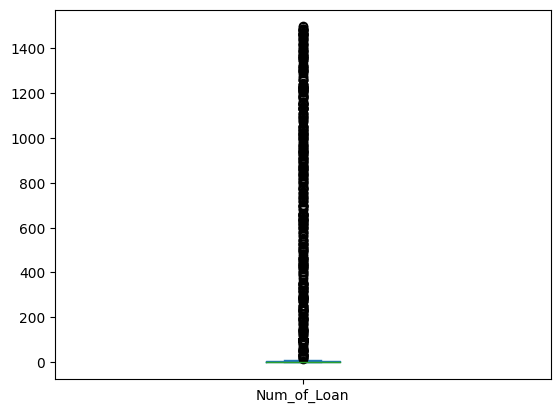

In [22]:
dataframe['Num_of_Loan'] = dataframe['Num_of_Loan'].apply(extract_number)
dataframe['Num_of_Loan'].plot(kind='box');

Using the above box plot we will consider ``Num_of_Loan > 10`` as an oulier and then try to fit a Median using Customer_ID.

In [23]:
dataframe.loc[dataframe['Num_of_Loan'] > 10, 'Num_of_Loan'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_of_Loan'].transform('median')
dataframe['Num_of_Loan'] = dataframe['Num_of_Loan'].fillna(medians)

### 1.1.10 Type_of_Loan

In [24]:
# Find all the Unique types of loan
dataframe['Type_of_Loan'].fillna('Not Specified', inplace=True)

unique_loans = set()
for loan_string in dataframe['Type_of_Loan']:
    loans = loan_string.split(',')
    loans = [loan.strip() for subloan in loans for loan in subloan.split('and')]
    unique_loans.update(loans)
unique_loans.remove('')

# Create New Columns for the Type of Loan
for loan in unique_loans:
    dataframe[f'Type_of_Loan_{loan}'] = 0

# Fill number of occurrence in each column if the customer has taken a specific type of loan
for index, row in dataframe.iterrows():
    for loan in unique_loans:
        dataframe.at[index, f'Type_of_Loan_{loan}'] = row['Type_of_Loan'].count(loan)

# Dropping the original Column
dataframe.drop(columns=['Type_of_Loan'], inplace=True)

### 1.1.11 Num_of_Delayed_Payment

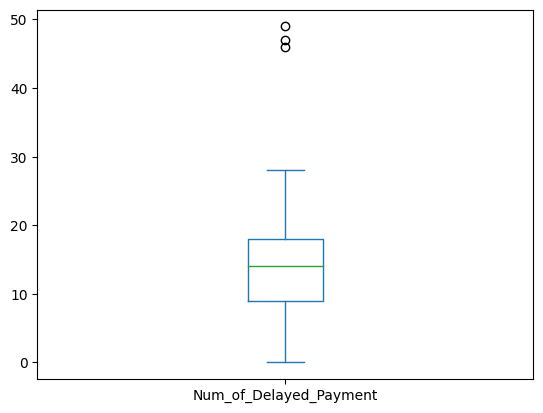

In [25]:
def extract_number_with_NaNs(s):
    if pd.isna(s):
        return s

    return int(re.sub(r"[^0-9]", "", s))

dataframe['Num_of_Delayed_Payment'] = dataframe['Num_of_Delayed_Payment'].apply(extract_number_with_NaNs)
dataframe[dataframe['Num_of_Delayed_Payment'] <= 50]['Num_of_Delayed_Payment'].plot(kind='box');

Using the above box plot we will consider ``Num_of_Delayed_Payment > 30`` as an oulier and then try to fit a Median using Customer_ID.

In [26]:
dataframe.loc[dataframe['Num_of_Delayed_Payment'] > 30, 'Num_of_Delayed_Payment'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform('median')
dataframe['Num_of_Delayed_Payment'] = dataframe['Num_of_Delayed_Payment'].fillna(medians)

### 1.1.12 Changed_Credit_Limit

In [27]:
dataframe['Changed_Credit_Limit'].replace("_", 0.0, inplace=True)
dataframe['Changed_Credit_Limit'] = dataframe['Changed_Credit_Limit'].astype('float32')

### 1.1.13 Num_Credit_Inquiries

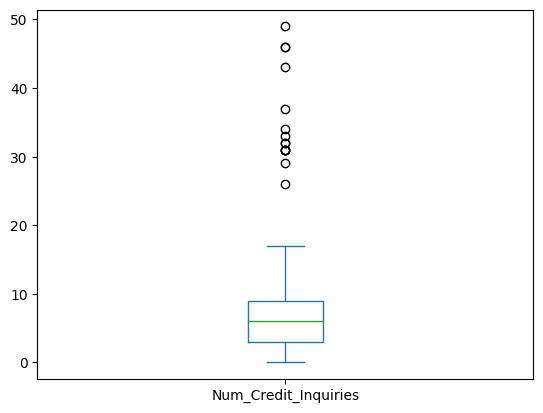

In [28]:
dataframe[dataframe['Num_Credit_Inquiries'] < 50]['Num_Credit_Inquiries'].plot(kind='box');

In [29]:
dataframe.loc[dataframe['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan
medians = dataframe.groupby('Customer_ID')['Num_Credit_Inquiries'].transform('median')
dataframe['Num_Credit_Inquiries'] = dataframe['Num_Credit_Inquiries'].fillna(medians)

### 1.1.14 Credit_Mix

In [30]:
credit_mix_map = {'_': np.nan, 'Bad': 0, 'Standard': 1, 'Good': 2}
dataframe['Credit_Mix'] = dataframe['Credit_Mix'].map(credit_mix_map)
medians = dataframe.groupby('Customer_ID')['Credit_Mix'].transform('median')
dataframe['Credit_Mix'] = dataframe['Credit_Mix'].fillna(medians)

### 1.1.15 Outstanding_Debt

In [31]:
dataframe['Outstanding_Debt'] = dataframe['Outstanding_Debt'].apply(extract_float)

### 1.1.16 Credit_History_Age

In [32]:
def extract_months(value):
    if pd.isna(value):
        return value
    match = re.match(r'(\d+)\s*Years\s*and\s*(\d+)\s*Months', value)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years * 12 + months
    return value

dataframe['Credit_History_Age'] = dataframe['Credit_History_Age'].apply(extract_months)
medians = dataframe.groupby('Customer_ID')['Credit_History_Age'].transform('median')
dataframe['Credit_History_Age'] = dataframe['Credit_History_Age'].fillna(medians)

### 1.1.17 Payment_of_Min_Amount

Payment_of_Min_Amount column has 3-Distinct values ``Yes``, ``No`` & ``NM``. We are assuming that ``NM`` means ``Not Mentioned``. So we will map the values of ``No to 0``, ``NM to 1`` & ``Yes to 2``.

In [33]:
payment_min_amt_map = {'No': 0, 'NM': 1, 'Yes': 2}
dataframe['Payment_of_Min_Amount'] = dataframe['Payment_of_Min_Amount'].map(payment_min_amt_map)

### 1.1.18 Total_EMI_per_month

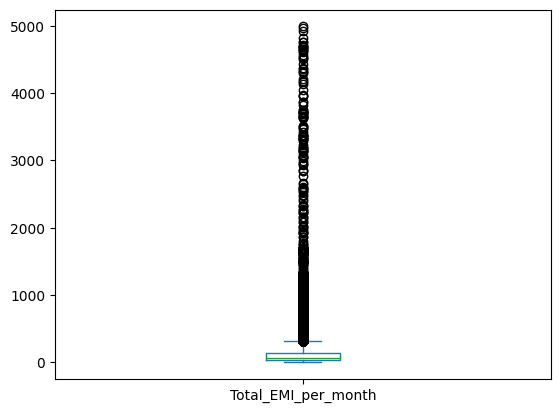

In [34]:
dataframe['Total_EMI_per_month'] = dataframe['Total_EMI_per_month'].round(2)
dataframe[dataframe['Total_EMI_per_month'] < 5000]['Total_EMI_per_month'].plot(kind='box');

This columns variation is very large. There are some customer who have actually make some high payment. But also we believe there are some values are very unusual and we need to replace them with the Median of the Customer Total_EMI_per_month. We will decide the maximum value of the Total_EMI_per_month using Mean and Standard Deviation.
$$
\text{Upper Bound} = \mu + 3 \times \sigma
$$

In [35]:
mean = dataframe['Total_EMI_per_month'].mean()
std = dataframe['Total_EMI_per_month'].std()
upper_bound = mean + 3*std

dataframe.loc[dataframe['Total_EMI_per_month'] > upper_bound, 'Total_EMI_per_month'] = np.nan
medians = dataframe.groupby('Customer_ID')['Total_EMI_per_month'].transform('median')
dataframe['Total_EMI_per_month'] = dataframe['Total_EMI_per_month'].fillna(medians)

### 1.1.20 Amount_invested_monthly

In [36]:
def extract_float_with_NaNs(s):
    if pd.isna(s):
        return s
    
    return float(re.sub(r"[^0-9.]", "", s))

dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].apply(extract_float_with_NaNs)

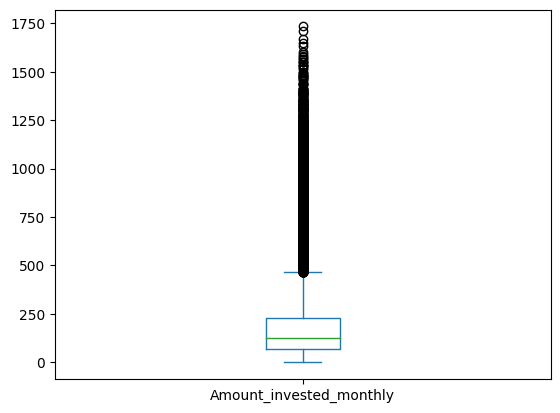

In [37]:
dataframe[dataframe['Amount_invested_monthly'] < 4000]['Amount_invested_monthly'].plot(kind='box');

Using the above box plot we will consider ``Amount_invested_monthly > 1750`` as an oulier and then try to fit a Mean using Customer_ID.

In [38]:
dataframe.loc[dataframe['Amount_invested_monthly'] > 1750, 'Amount_invested_monthly'] = np.nan
means = dataframe.groupby('Customer_ID')['Amount_invested_monthly'].transform('mean')
dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].fillna(means)
dataframe['Amount_invested_monthly'] = dataframe['Amount_invested_monthly'].round(2)

### 1.1.21 Payment_Behaviour

In [39]:
dataframe['Payment_Behaviour'].replace("!@9#%8", "Not_Specified", inplace=True)
encoded_payment_behaviours = pd.get_dummies(dataframe['Payment_Behaviour'], prefix='PB')
dataframe = pd.concat([dataframe.drop('Payment_Behaviour', axis=1), encoded_payment_behaviours], axis=1)

### 1.1.22 Monthly_Balance

In [40]:
# There was only one bad value in this Column
dataframe['Monthly_Balance'].replace("__-333333333333333333333333333__", np.nan, inplace=True)

dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].astype('float64')
means = dataframe.groupby('Customer_ID')['Monthly_Balance'].transform('mean')
dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].fillna(means)
dataframe['Monthly_Balance'] = dataframe['Monthly_Balance'].round(2)

### 1.1.23 Credit_Score

In [41]:
credit_score_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
dataframe['Credit_Score'] = dataframe['Credit_Score'].map(credit_score_map)

### 1.1.24 Dropping Unnecessary Columns

In [42]:
dataframe.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'], inplace=True)

### A look at our data after feature engineering

In [43]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97212 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   97212 non-null  float64
 1   Annual_Income                         97212 non-null  float64
 2   Monthly_Inhand_Salary                 97212 non-null  float64
 3   Num_Bank_Accounts                     97212 non-null  float64
 4   Num_Credit_Card                       97212 non-null  float64
 5   Interest_Rate                         97212 non-null  float64
 6   Num_of_Loan                           97212 non-null  float64
 7   Delay_from_due_date                   97212 non-null  int64  
 8   Num_of_Delayed_Payment                97212 non-null  float64
 9   Changed_Credit_Limit                  97212 non-null  float32
 10  Num_Credit_Inquiries                  97212 non-null  float64
 11  Credit_Mix          

In [44]:
dataframe.to_csv('Data/After_Feature_Engineering.csv', index=False)